# Spectral analysis of ECG signal using Python packages. 

Or use frequencies to get embeddings (use images of ECG)

- Fourier & Wavelet Spectrograms

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from scipy.signal import resample
import torch
from transformers import AutoTokenizer, AutoModel
import ast
import scipy.io as sio
from scipy.signal import spectrogram
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from scipy.fft import fft
import pywt

c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
sys.path.append('C:/Users/navme/Desktop/ECG_Project/PyFiles')

In [4]:
from helper_functions import *

In [5]:
PhysioNet_PATH = f'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'
PhysioNet_PATH

'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'

In [6]:
smowmed_mappings_path = 'C:/Users/navme/Desktop/ECG_Project/Data/SNOWMED-CT Codes/combined_mappings.csv'

# Load the SNOMED-CT mappings
smowmed_mappings = pd.read_csv(smowmed_mappings_path)
smowmed_mappings.head(2)

,Dx,SNOMEDCTCode,Abbreviation,CPSC,CPSC_Extra,StPetersburg,PTB,PTB_XL,Georgia,Chapman_Shaoxing,Ningbo,Total,Notes
0,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,1780,0,5255,NaN
1,atrial flutter,164890007,AFL,0,54,0,1,73,186,445,7615,8374,NaN


In [7]:
# Select the 'Dx' and 'SNOMEDCTCode' columns
codes = smowmed_mappings[['Dx', 'SNOMEDCTCode']]

# Set 'SNOWMEDCTCode' as the index
codes.set_index('SNOMEDCTCode', inplace=True)

# Convert the DataFrame into a dictionary
codes_dict = codes['Dx'].to_dict()

In [8]:
list(codes_dict.items())[:5]

[(164889003, 'atrial fibrillation'),
 (164890007, 'atrial flutter'),
 (6374002, 'bundle branch block'),
 (426627000, 'bradycardia'),
 (733534002, 'complete left bundle branch block')]

In [9]:
class PhysioNetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=False):
        self.dataset_path = dataset_path
        self.dataset_path = [path for path in self.dataset_path if "index.html" not in path]
        self.train = train
        self.file_list = os.listdir(dataset_path)
        self._hea_files = []
        self._mat_files = []
        self._indices_files = []
        self._hea_files_path = []
        self._mat_files_path = []

        self.file_PATHS = []  # Directory to main database folders
        self.data_files = []  # Directory to data files

        # Validation Case: PTB Databases only
        if self.train == False:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        # Training Case: All Databases excluding PTB
        else:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file not in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        for path in self.file_PATHS:
            if os.path.isdir(path):
                for sub_folder in os.listdir(path):
                    sub_folder_path = os.path.join(path, sub_folder)
                    sub_folder_path = sub_folder_path.replace('\\', '/')

                    # Ignore index.html files
                    if sub_folder_path.endswith('index.html'):
                        self._indices_files.append(sub_folder_path)
                    else:
                        if os.path.isdir(sub_folder_path):
                            for file in os.listdir(sub_folder_path):
                                # Get all .hea files
                                if file.endswith('.hea'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._hea_files.append(file_path)
                                    self._hea_files_path.append(file_path)
                                # Get all .mat files
                                elif file.endswith('.mat'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._mat_files.append(file_path)
                                    self._mat_files_path.append(file_path)

    def resample_ecg(self, ecg, new_length=1280):
        # Get the current length of the ECG
        current_length = ecg.shape[1]

        # Resample the ECG
        resampled_ecg = resample(ecg, new_length, axis=1)

        return resampled_ecg

    def __getitem__(self, index):
        if isinstance(index, slice):
            start, stop, step = index.indices(len(self))
            return [self[i] for i in range(start, stop, step)]
        # 1. Get .hea file
        hea_file_path = self._hea_files[index]
        with open(hea_file_path, 'r') as f:
            lines = f.readlines()

        dx_modalities = None
        # Parse header information
        for line in lines:
            if line.startswith('# Dx:'):
                dx_codes = line.split(':')[1].strip().split(',')
                dx_modalities = [codes_dict.get(int(code.strip()), code.strip()) for code in dx_codes]

        # 2. Get .mat file
        mat_file_path = None
        twelve_lead_ecg = None
        if index < len(self._mat_files):
            mat_file_path = self._mat_files[index]
            mat_data = sio.loadmat(mat_file_path)

            # Extract the ECG data
            twelve_lead_ecg = mat_data['val']

            # Resample the ECG if it is not None
            twelve_lead_ecg = self.resample_ecg(twelve_lead_ecg)

        else:
            print(f"MAT file for index {index} does not exist.")

        # Return list of diagnoses, the np array of the 12-lead ECG, and the path to the .mat file
        return dx_modalities, twelve_lead_ecg, mat_file_path

    def plot_record(self, index):
        mat_file_path = self._mat_files[index]
        data = sio.loadmat(mat_file_path)

        # Resample the ECG data
        resampled_data = self.resample_ecg(data['val'])

        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

        for i, ax in enumerate(axs.flat):
            ax.plot(resampled_data[i], linewidth=0.5)
            ax.set_xlabel('Sample')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Lead {i+1}')

        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self._hea_files)

In [10]:
expA_dataset = PhysioNetDataset(PhysioNet_PATH, train=False)
len(expA_dataset)  # Should be 22353 records in total

22352

In [11]:
expA_dataset[0][1]

array([[ -45.93443974, -257.76735841, -204.38884819, ...,  207.06125242,
         229.91846005,  241.06771077],
       [   2.39774601, -258.27448051, -213.23767774, ...,  236.74978869,
         163.10069387,  266.09279668],
       [  48.77130997,   -0.55561737,   -8.93666839, ...,   30.38791226,
         -66.5753722 ,   25.43929824],
       ...,
       [   6.93659186,  136.56480991,   83.44371554, ..., -109.00235325,
         -82.10284084,  -65.32595022],
       [  40.00654719,  231.07221173,  161.53286103, ..., -171.11330299,
        -169.96584404, -174.2212556 ],
       [  18.56012414,  231.41053703,  158.34203376, ..., -215.72758534,
        -208.84775154, -226.52649213]])

# ECGSpectrogramGenerator()

In [12]:
import scipy.io as sio
import os
import matplotlib.pyplot as plt

class ECGSpectrogramGenerator:
    def __init__(self, save_dir):
        self.save_dir = save_dir

    def generate_spectrogram(self, mat_file, recording_number):
        # Load the ECG signal from the .mat file
        ecg_signal = sio.loadmat(mat_file)['val']
        
        # Generate a spectrogram for each lead
        for lead_id, lead_signal in enumerate(ecg_signal):
            plt.figure(figsize=(14, 5))
            Pxx, freqs, bins, im = plt.specgram(lead_signal, NFFT=1024, Fs=128, noverlap=900, cmap='jet')
            plt.title(f'Spectrogram of ECG signal {recording_number}, lead {lead_id}')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.colorbar(label='Intensity')
            
            # Save the figure as an image
            plt.savefig(os.path.join(self.save_dir, f'spectrogram_{recording_number}_lead_{lead_id}.png'), dpi=300, bbox_inches='tight')
            plt.close()


In [18]:
class ECGSpectrogramGenerator:
    def __init__(self, save_dir):
        self.save_dir = save_dir

    def generate_spectrogram(self, mat_file, recording_number, num_leads=None):
        # Load the ECG signal from the .mat file
        ecg_signal = sio.loadmat(mat_file)['val']

        # Generate a spectrogram for each lead
        num_leads = num_leads or len(ecg_signal)  # Use all leads if num_leads is not specified
        for lead_id, lead_signal in enumerate(ecg_signal[:num_leads]):
            plt.figure(figsize=(14, 5))
            Pxx, freqs, bins, im = plt.specgram(lead_signal, NFFT=1024, Fs=128, noverlap=900, cmap='jet')
            plt.title(f'Spectrogram of ECG signal {recording_number}, lead {lead_id}')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.colorbar(label='Intensity')

            # Save the figure as an image
            plt.savefig(os.path.join(self.save_dir, f'spectrogram_{recording_number}_lead_{lead_id}.png'), dpi=300, bbox_inches='tight')
            plt.close()


In [19]:
ecg_spectrogram_generator = ECGSpectrogramGenerator('C:/Users/navme/Desktop/ECG_Project/Spectrograms')

In [17]:
for i in range(1):  # only process the first record. There should be 12 spectrogram images, one for each lead
    mat_file = expA_dataset._mat_files[i]
    recording_number = i  # or replace with actual recording number if available
    ecg_spectrogram_generator.generate_spectrogram(mat_file, recording_number)

In [20]:
ecg_spectrogram_generator.generate_spectrogram(mat_file=expA_dataset._mat_files[2], recording_number=1, num_leads=3)

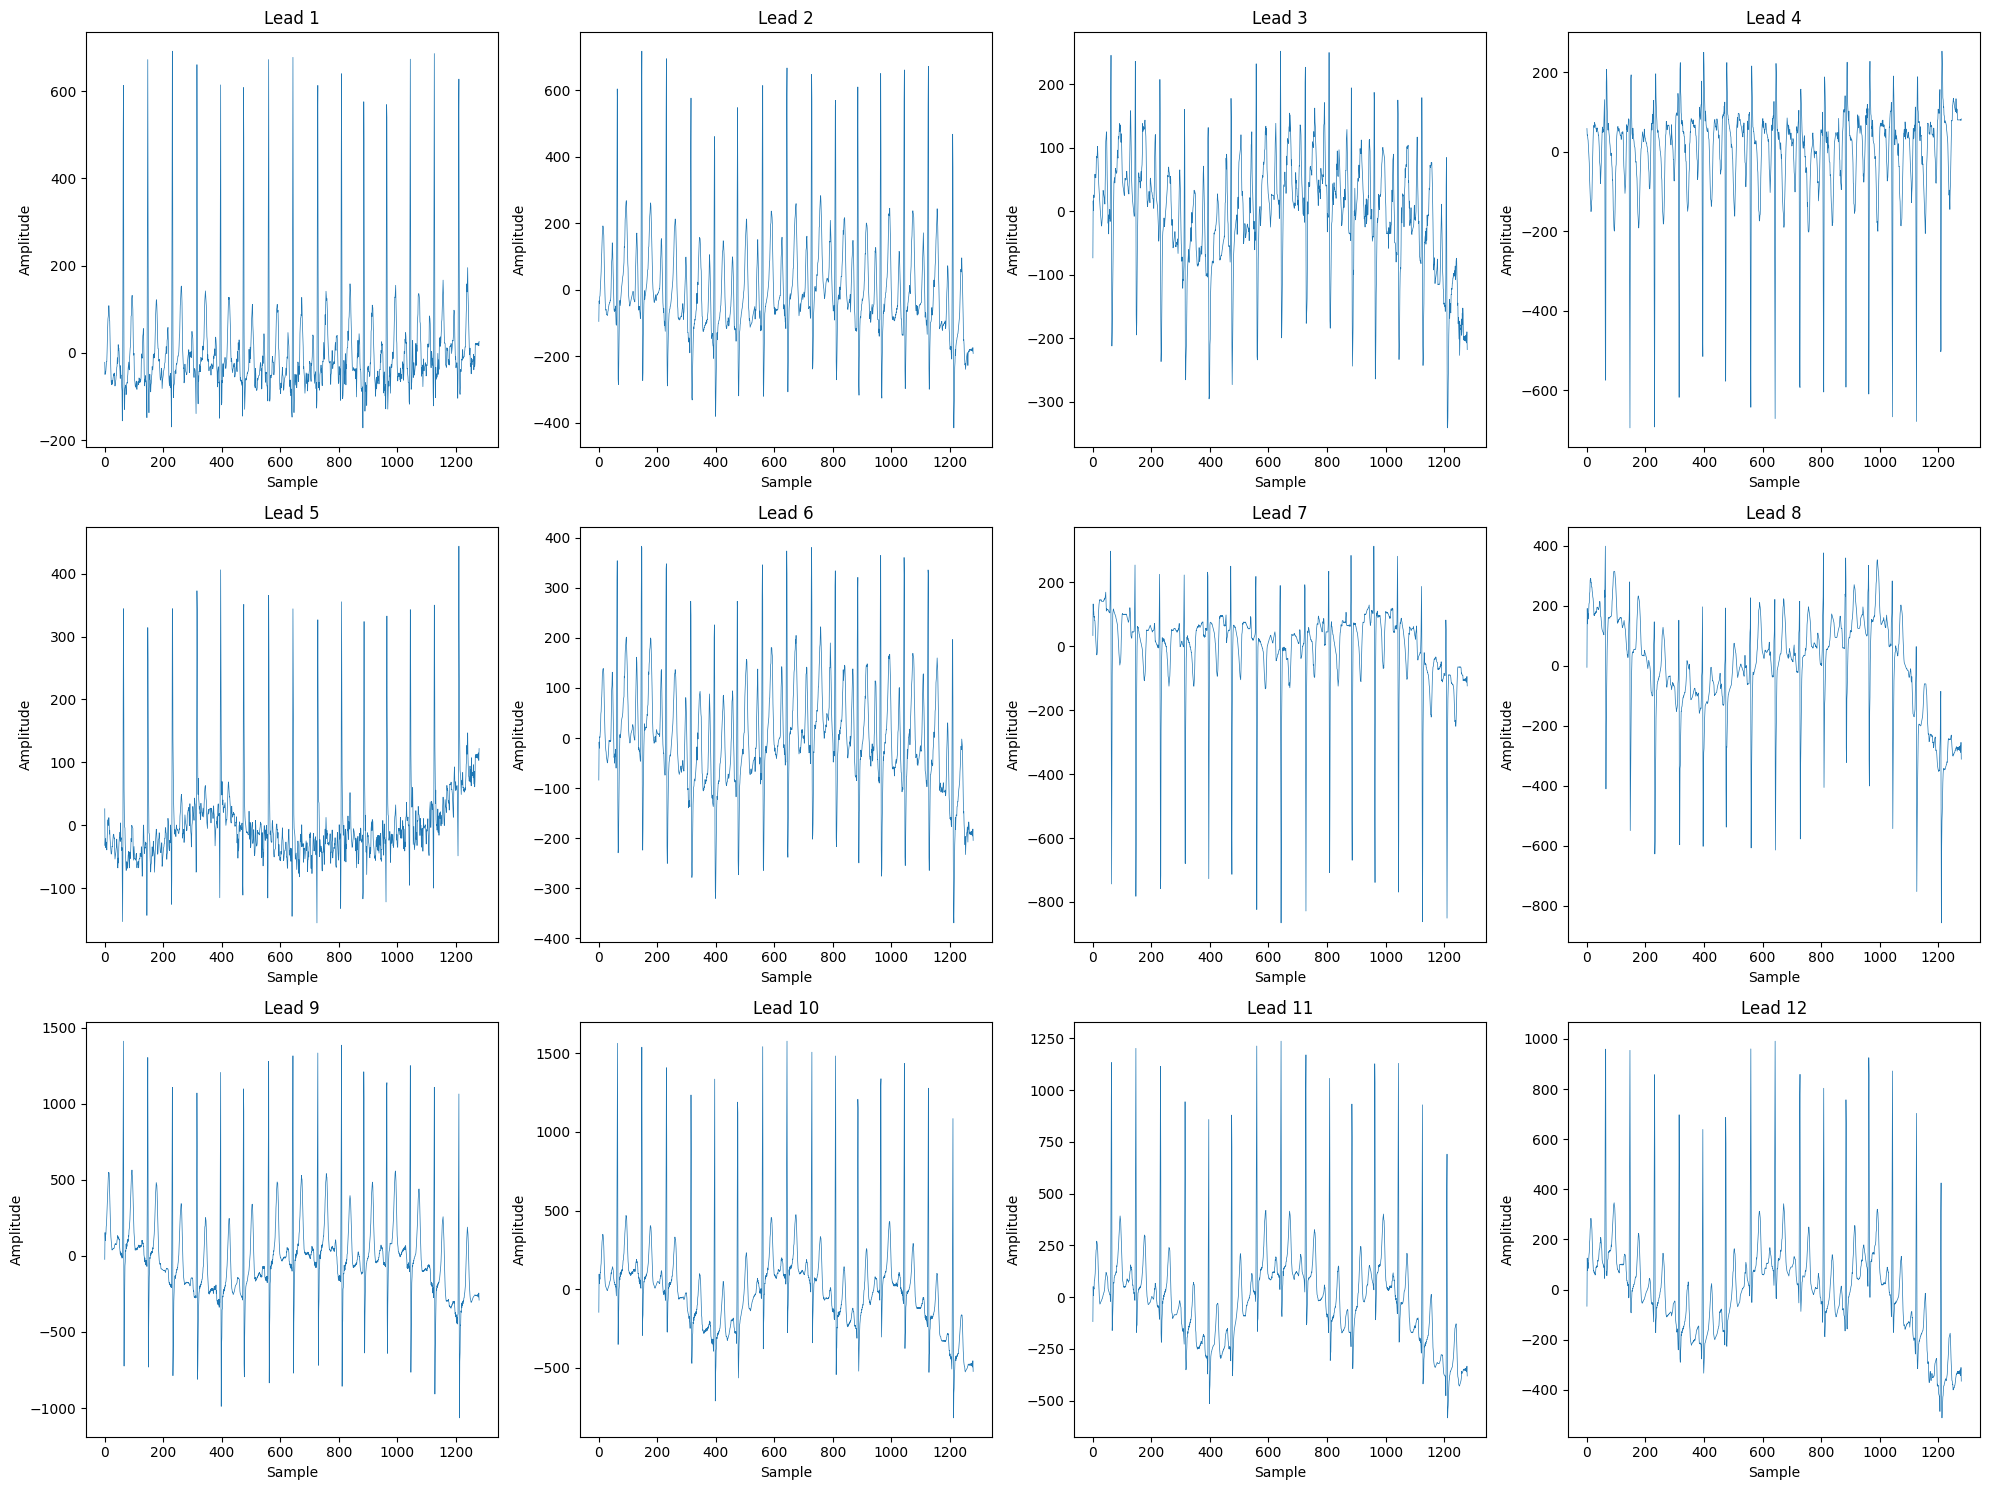

In [79]:
expA_dataset.plot_record(716)

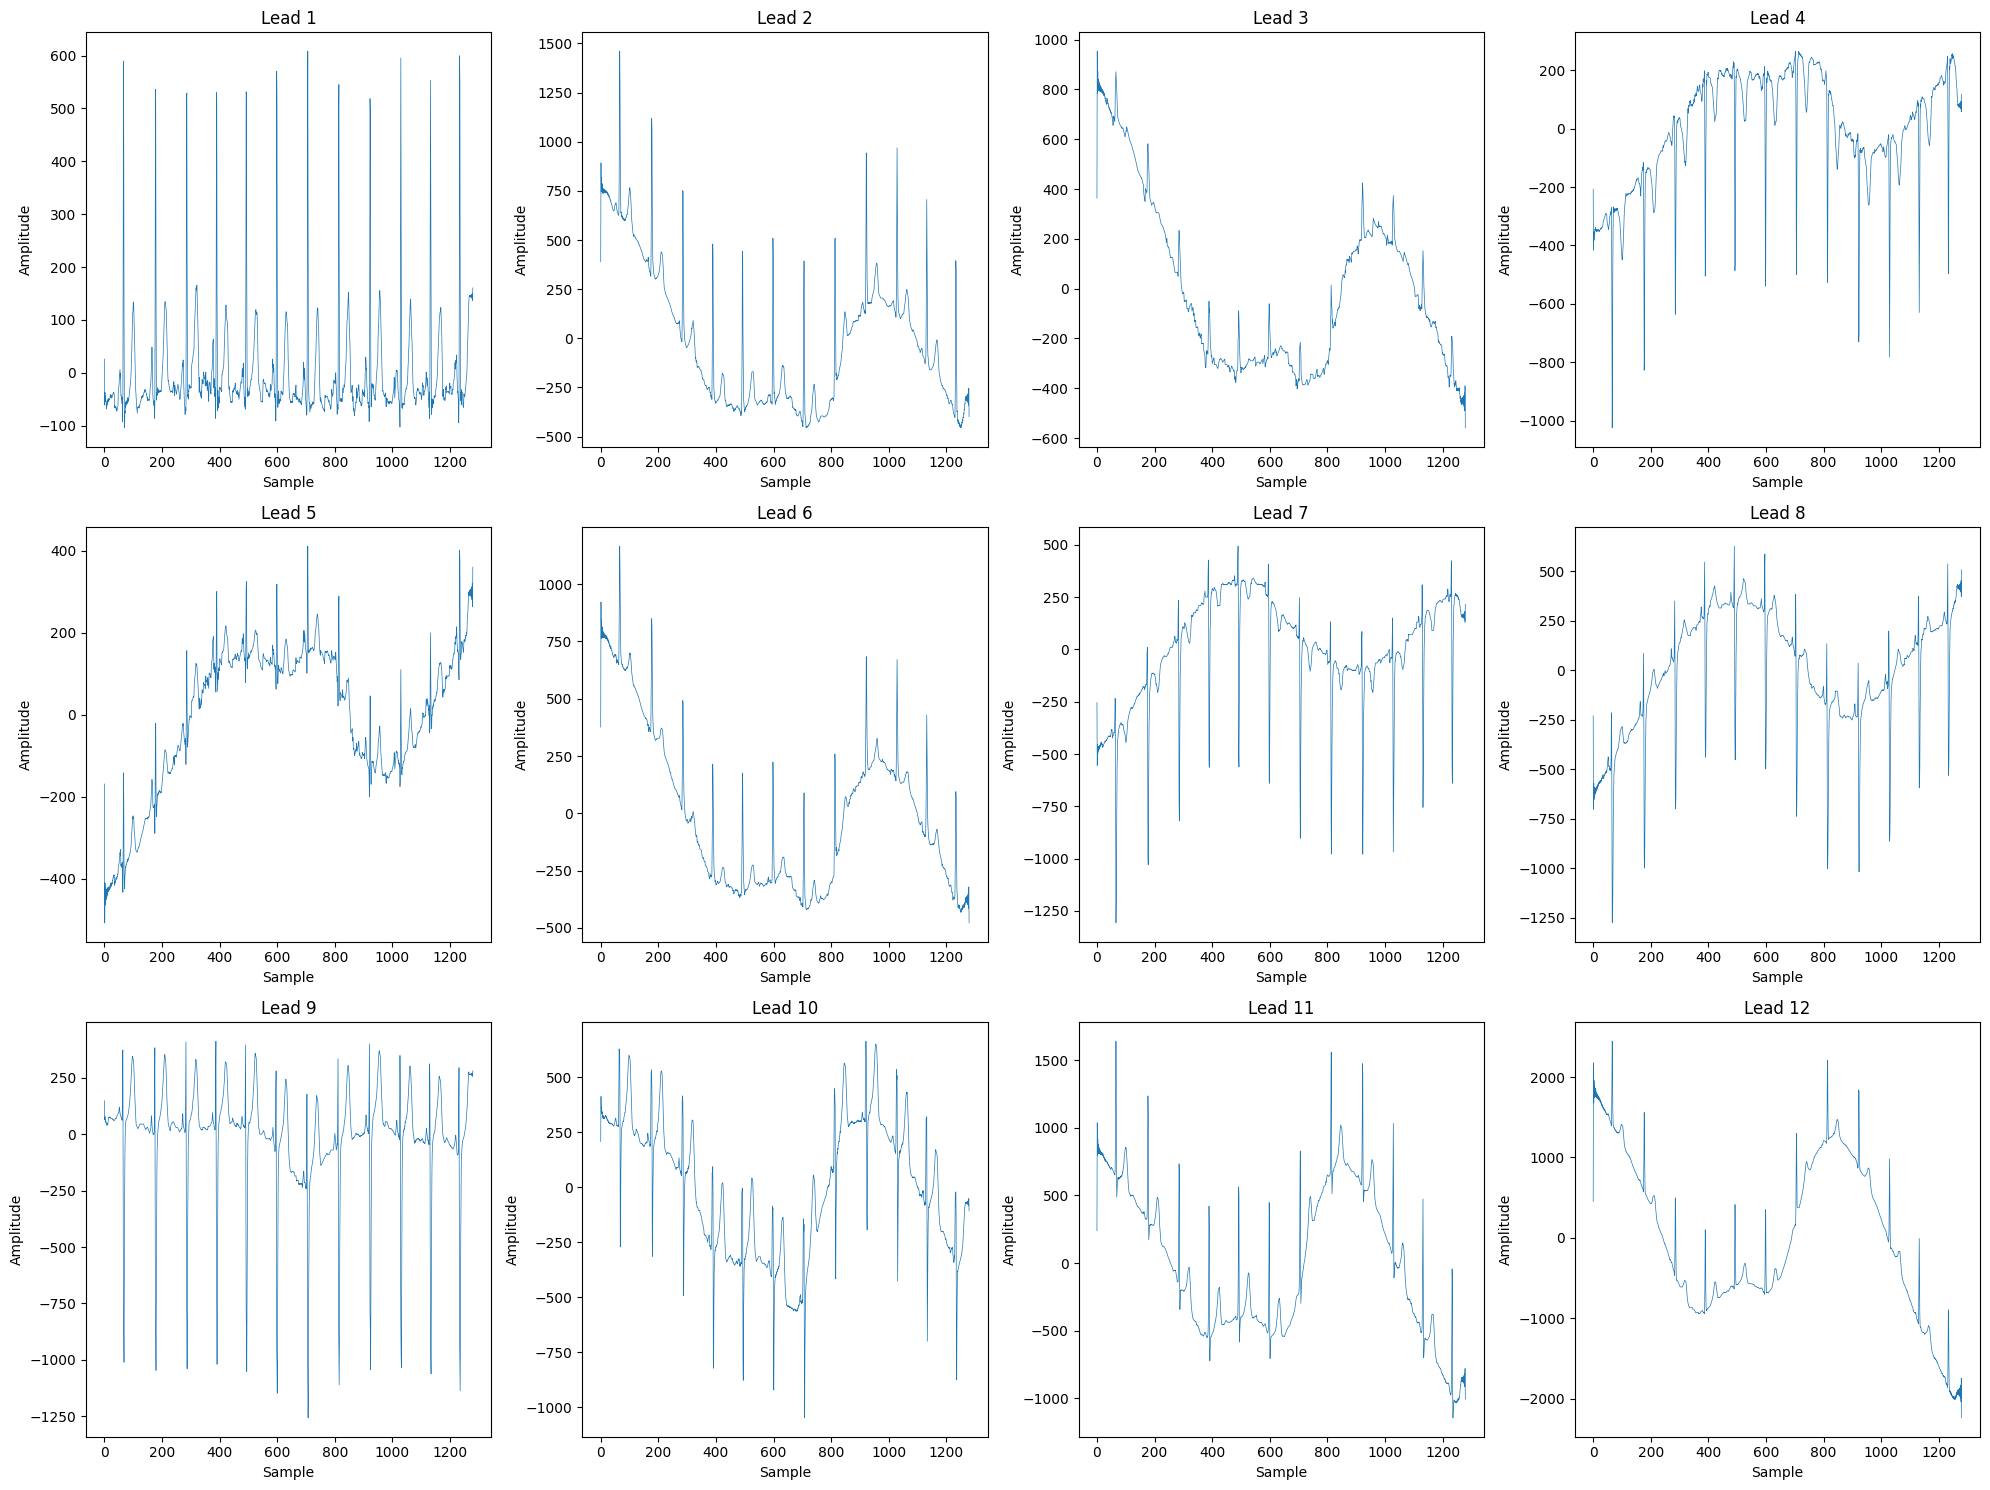

In [80]:
expA_dataset.plot_record(715)

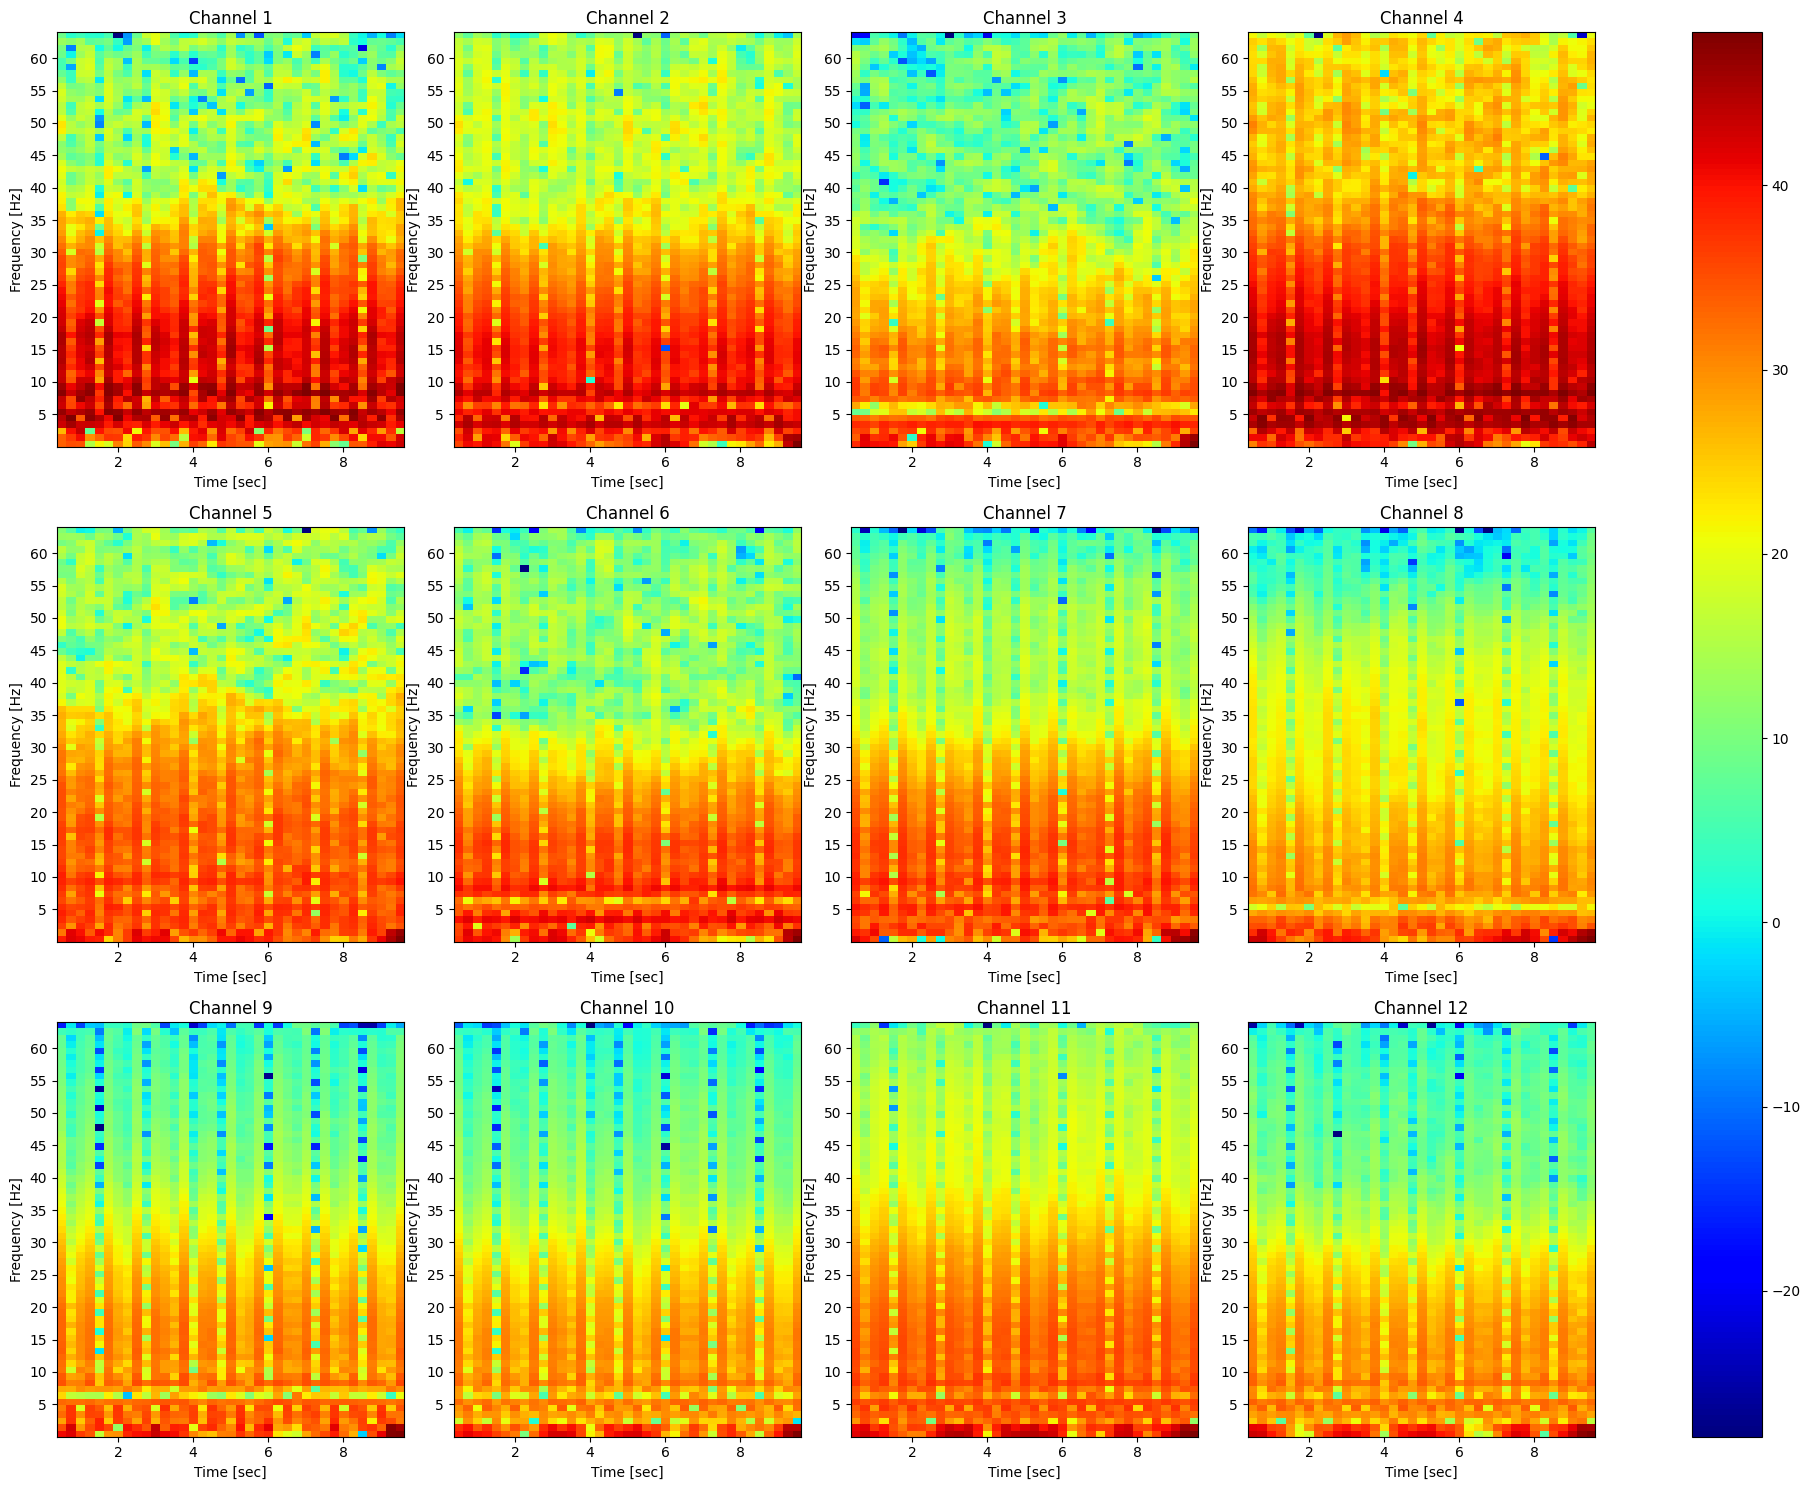

In [78]:
# Your multi-channel signal
signal = expA_dataset[716][1]

# Define the sampling frequency (this needs to be defined based on your data)
fs = 128  # replace with your actual sampling frequency

# Create a figure
fig, axs = plt.subplots(nrows=signal.shape[0]//4, ncols=4, figsize=(20, 15))

# Compute and plot the spectrogram for each channel
for i in range(signal.shape[0]):
    ax = axs[i // 4, i % 4]
    Pxx, freqs, bins, im = ax.specgram(signal[i], NFFT=128, Fs=fs, noverlap=96, mode='psd', cmap='jet')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f'Channel {i+1}')
    ax.set_yticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())

# Adjust the layout and add a colorbar
fig.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist())


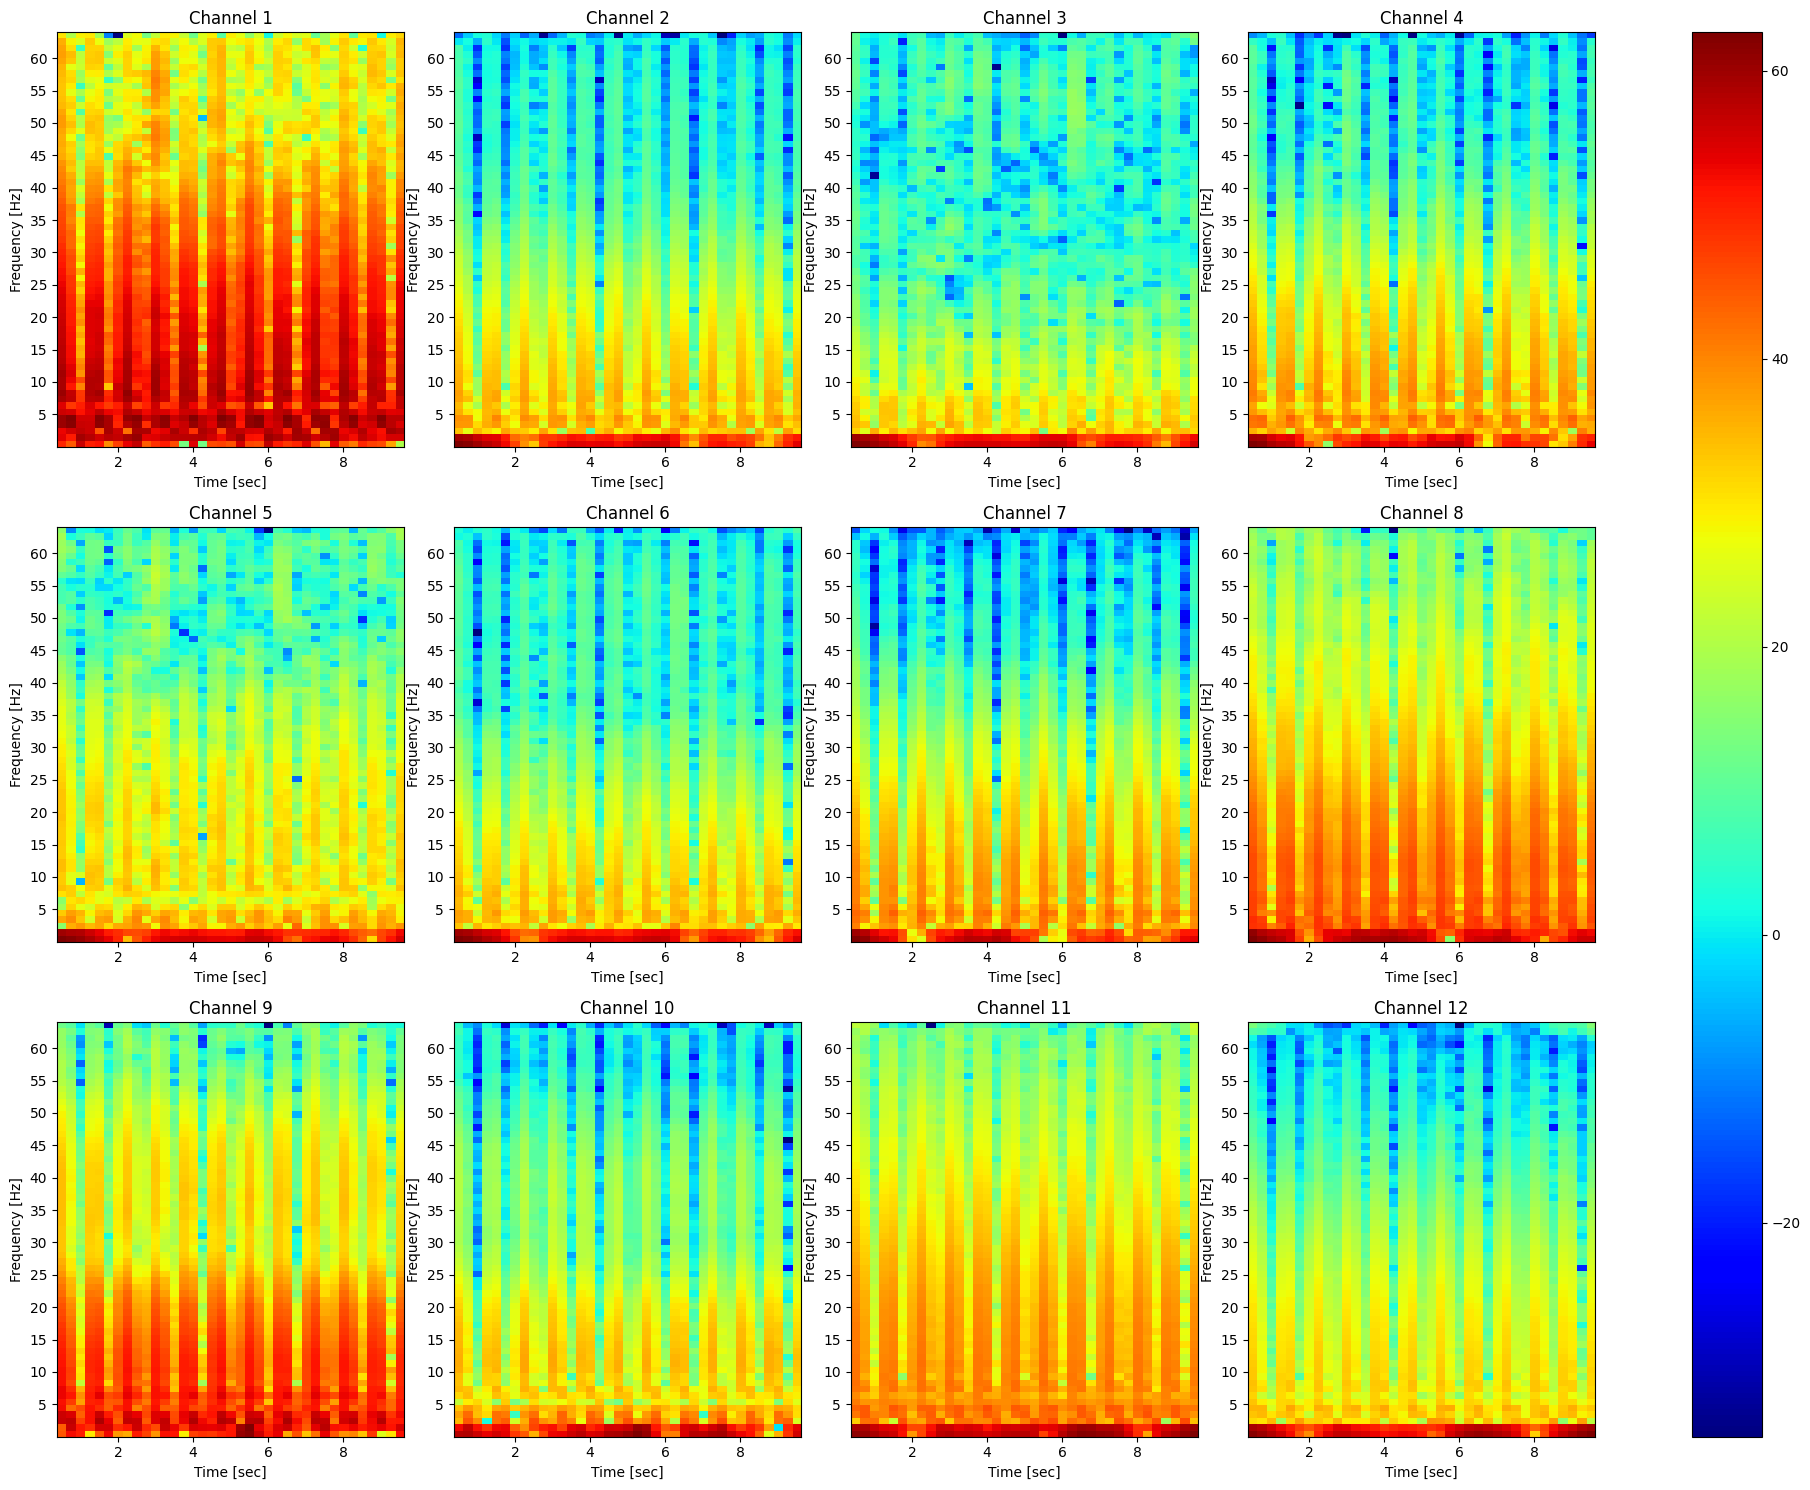

In [77]:
# Your multi-channel signal
signal = expA_dataset[715][1]

# Define the sampling frequency (this needs to be defined based on your data)
fs = 128  # replace with your actual sampling frequency

# Create a figure
fig, axs = plt.subplots(nrows=signal.shape[0]//4, ncols=4, figsize=(20, 15))

# Compute and plot the spectrogram for each channel
for i in range(signal.shape[0]):
    ax = axs[i // 4, i % 4]
    Pxx, freqs, bins, im = ax.specgram(signal[i], NFFT=128, Fs=fs, noverlap=96, mode='psd', cmap='jet')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f'Channel {i+1}')
    ax.set_yticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())

# Adjust the layout and add a colorbar
fig.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist())


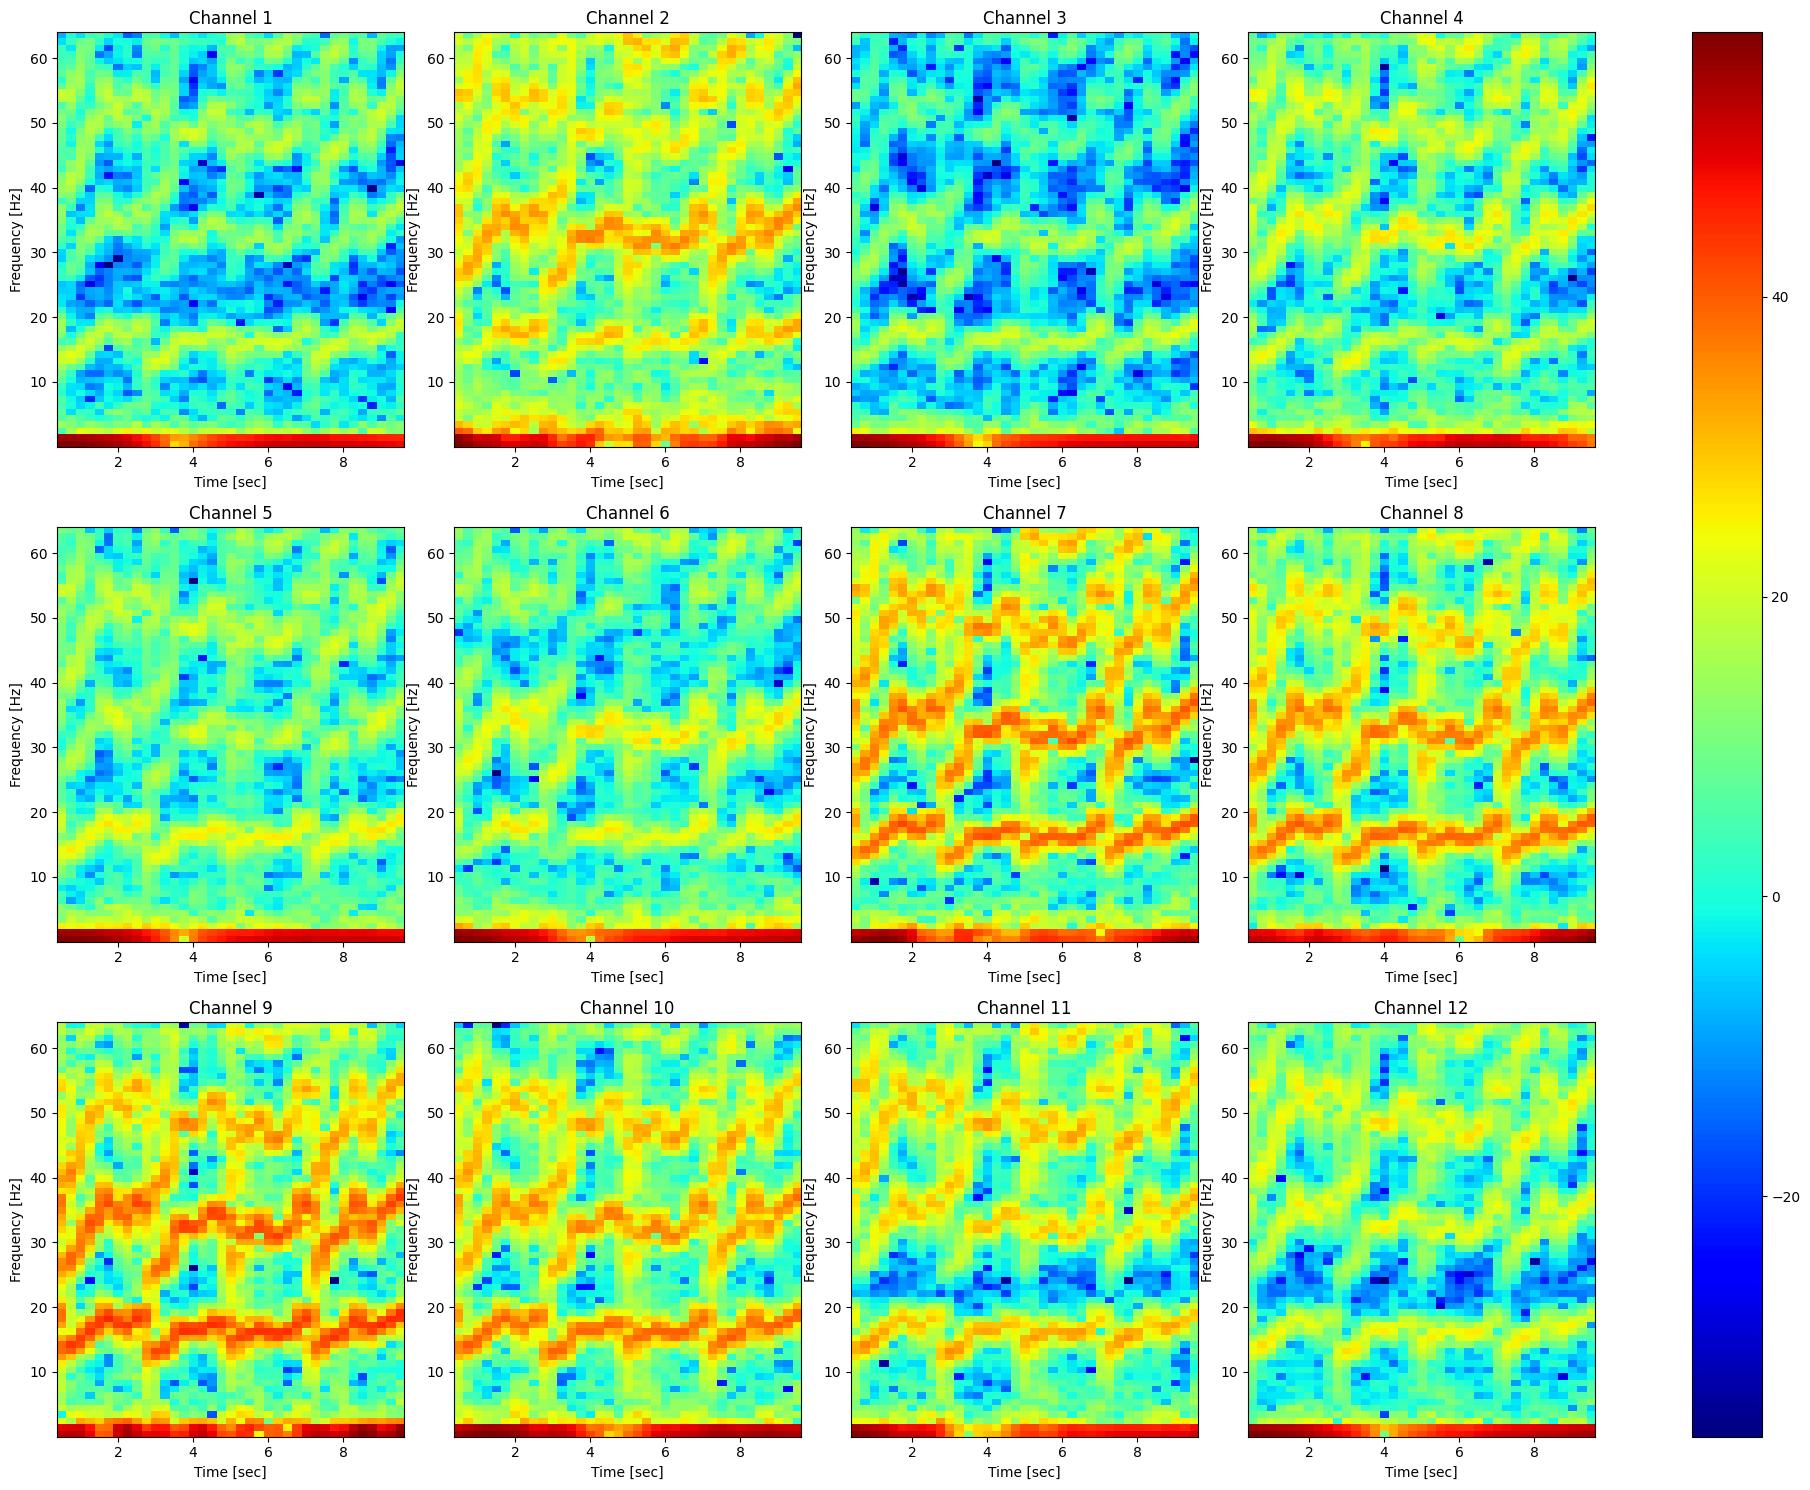

In [43]:
# Your multi-channel signal
signal = expA_dataset[455][1]

# Define the sampling frequency (this needs to be defined based on your data)
fs = 128  # replace with your actual sampling frequency

# Create a figure
fig, axs = plt.subplots(nrows=signal.shape[0]//4, ncols=4, figsize=(20, 15))

# Compute and plot the spectrogram for each channel
for i in range(signal.shape[0]):
    ax = axs[i // 4, i % 4]
    Pxx, freqs, bins, im = ax.specgram(signal[i], NFFT=128, Fs=fs, noverlap=96, mode='psd', cmap='jet')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f'Channel {i+1}')
    ax.set_yticks([10, 20, 30, 40, 50, 60])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())

# Adjust the layout and add a colorbar
fig.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist())

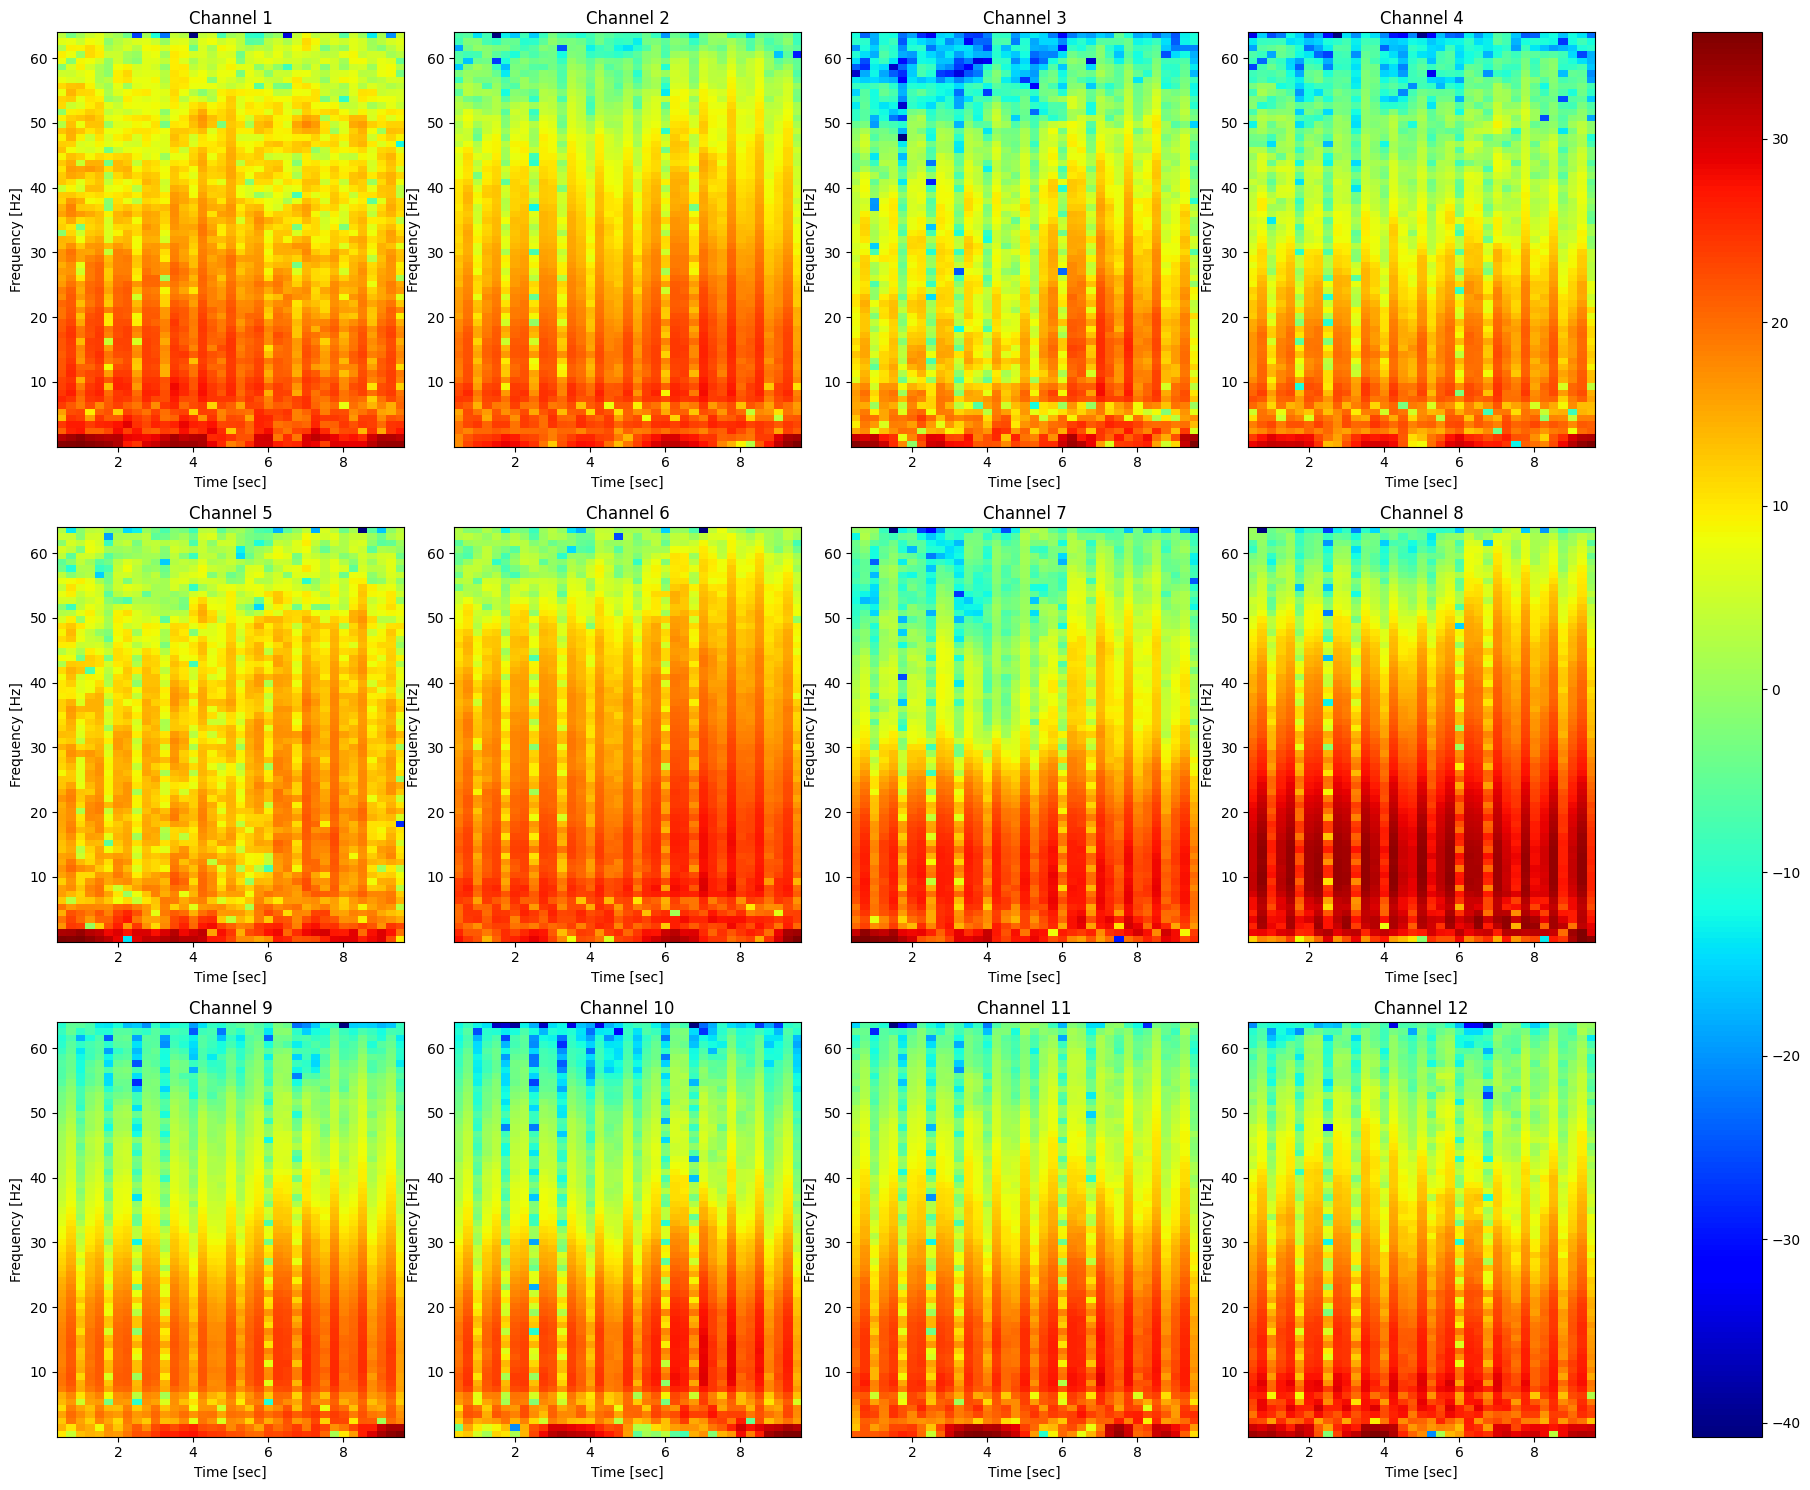

In [109]:
# Your multi-channel signal
signal = expA_dataset[6555][1]

# Define the sampling frequency (this needs to be defined based on your data)
fs = 128  # replace with your actual sampling frequency

# Create a figure
fig, axs = plt.subplots(nrows=signal.shape[0]//4, ncols=4, figsize=(20, 15))

# Compute and plot the spectrogram for each channel
for i in range(signal.shape[0]):
    ax = axs[i // 4, i % 4]
    Pxx, freqs, bins, im = ax.specgram(signal[i], NFFT=128, Fs=fs, noverlap=96, mode='psd', cmap='jet')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f'Channel {i+1}')
    ax.set_yticks([10, 20, 30, 40, 50, 60])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())

# Adjust the layout and add a colorbar
fig.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist())

In [98]:
expA_dataset[6555][0]

['t wave abnormal', 'sinus rhythm']

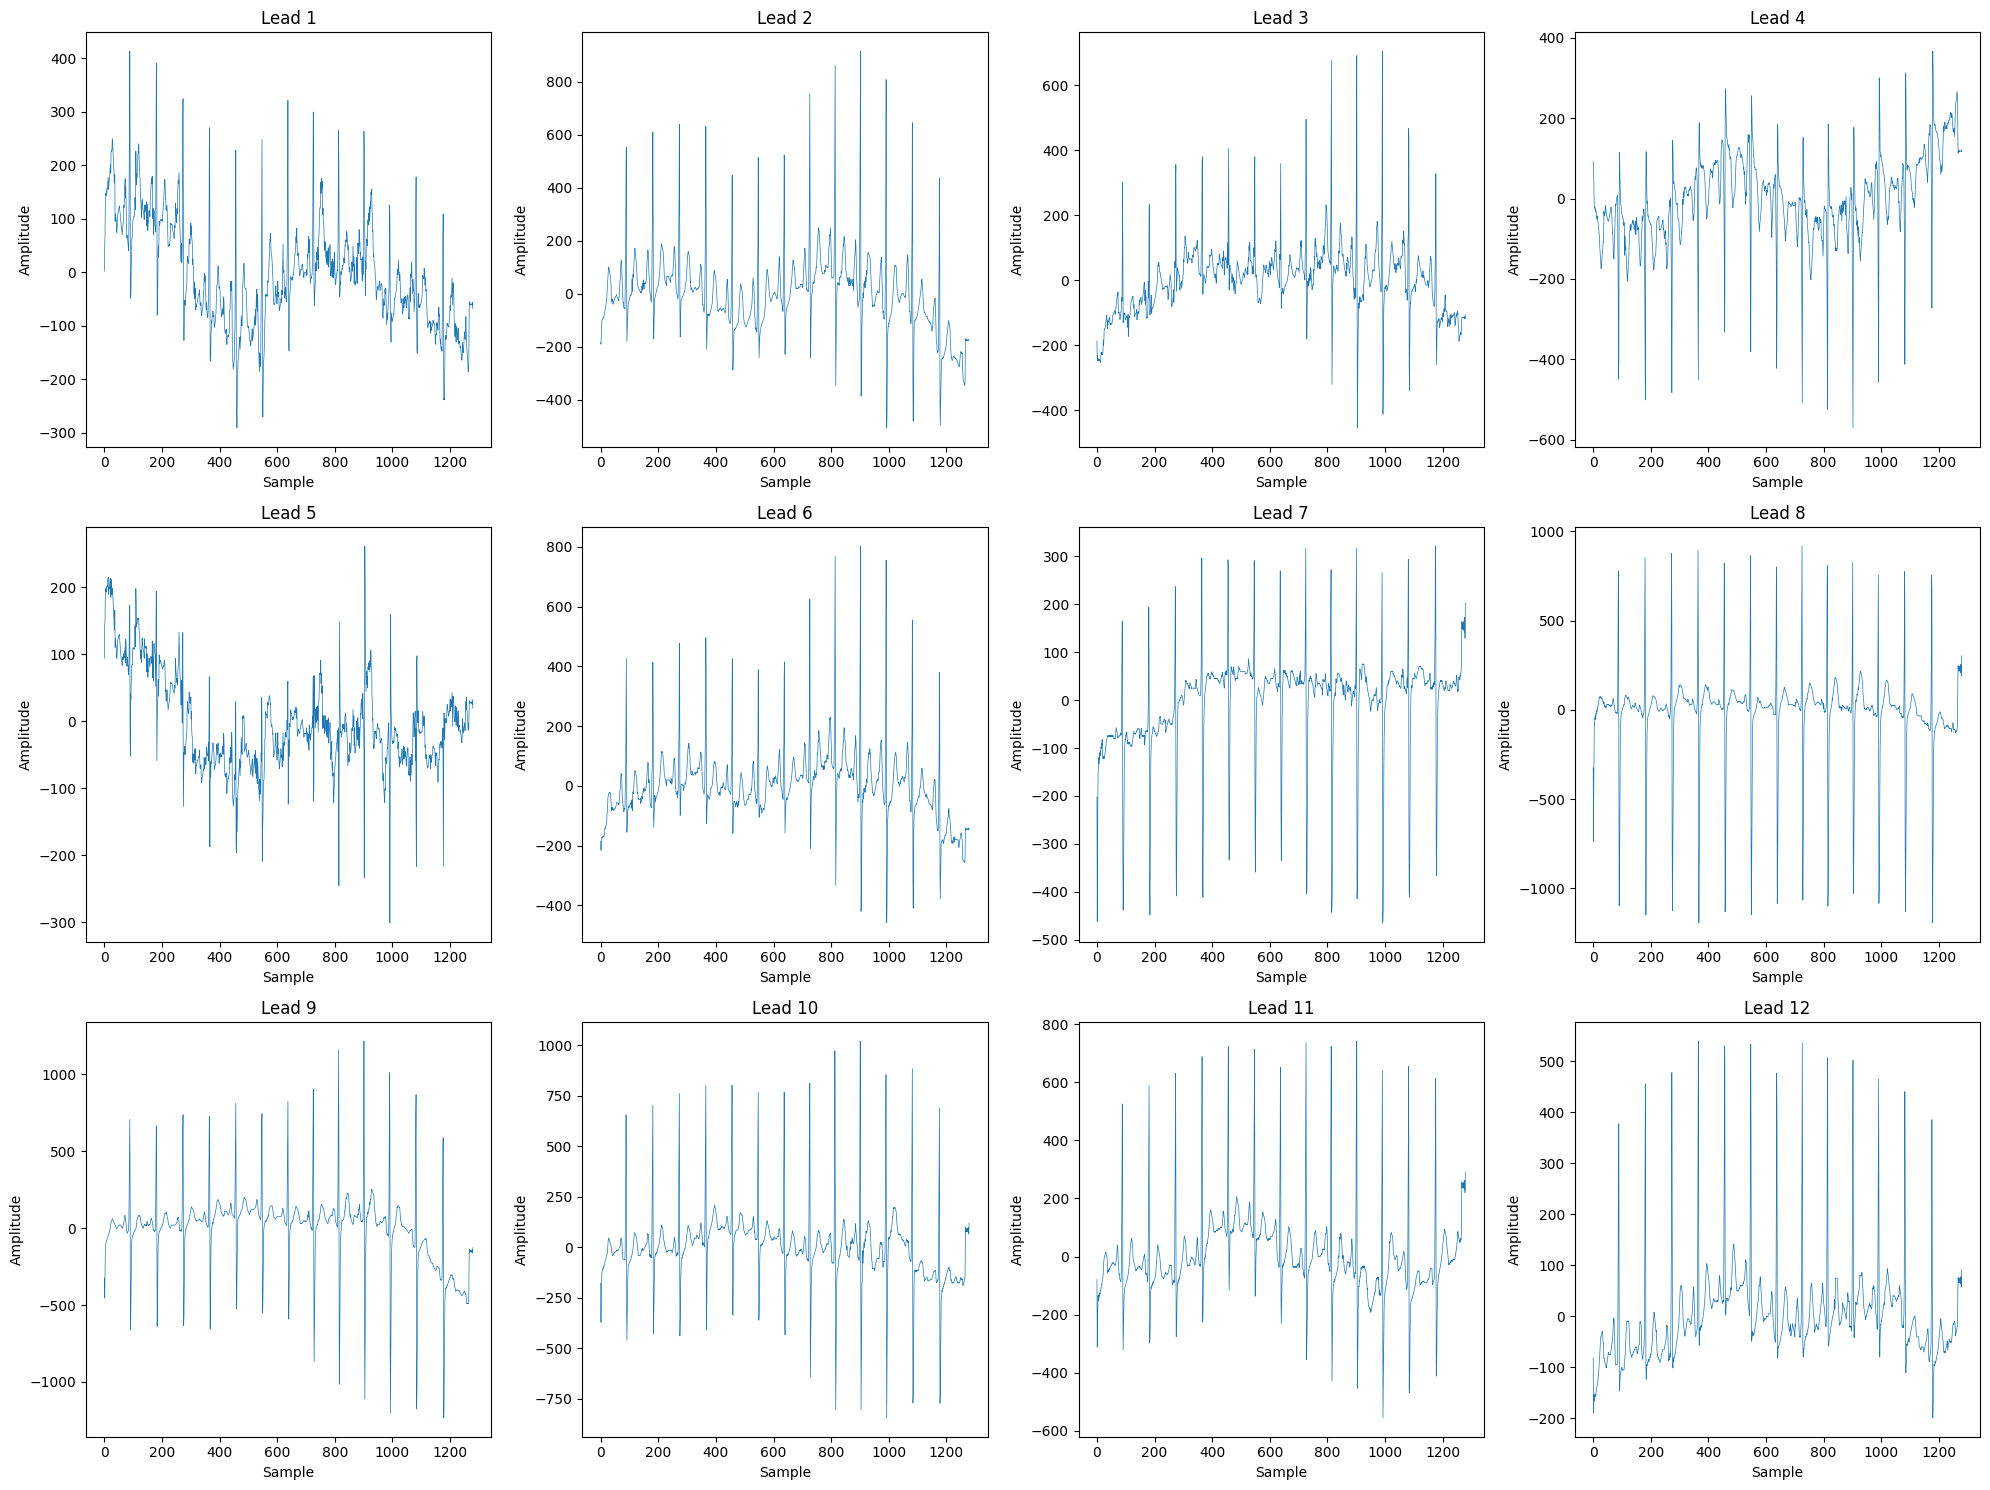

In [97]:
expA_dataset.plot_record(6555)

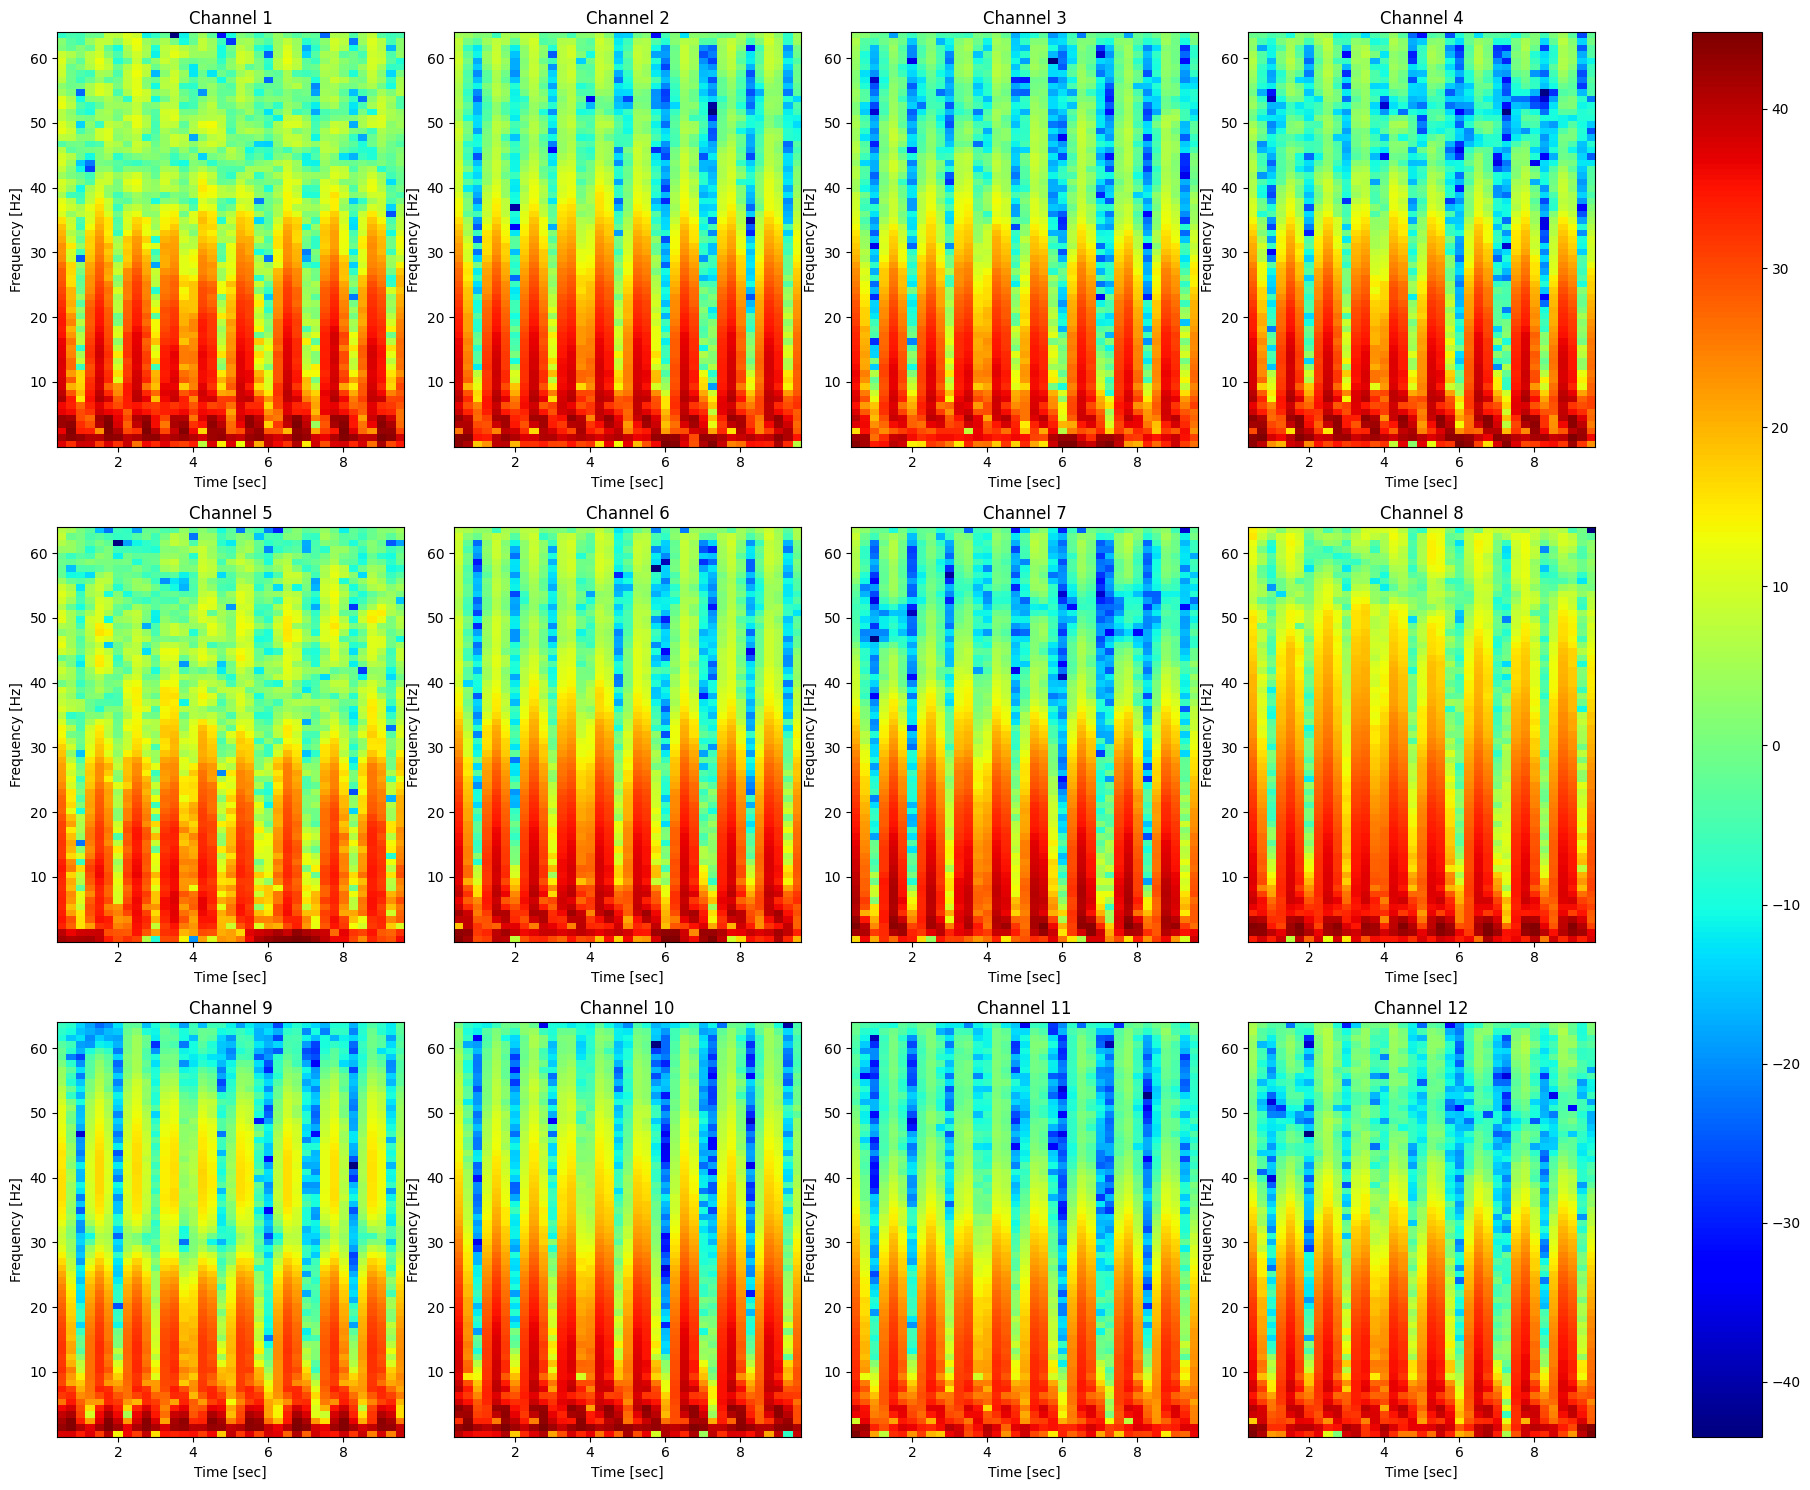

In [94]:
# Your multi-channel signal
signal = expA_dataset[6500][1]

# Define the sampling frequency (this needs to be defined based on your data)
fs = 128  # replace with your actual sampling frequency

# Create a figure
fig, axs = plt.subplots(nrows=signal.shape[0]//4, ncols=4, figsize=(20, 15))

# Compute and plot the spectrogram for each channel
for i in range(signal.shape[0]):
    ax = axs[i // 4, i % 4]
    Pxx, freqs, bins, im = ax.specgram(signal[i], NFFT=128, Fs=fs, noverlap=96, mode='psd', cmap='jet')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(f'Channel {i+1}')
    ax.set_yticks([10, 20, 30, 40, 50, 60])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())

# Adjust the layout and add a colorbar
fig.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist())

In [90]:
import matplotlib.pyplot as plt
import os
import scipy.io as sio

class ECGSpectrogramGenerator:
    def __init__(self, save_dir):
        self.save_dir = save_dir

    def generate_spectrogram(self, ecg_signal, recording_number, num_leads=None):
        # Generate a spectrogram for each lead
        num_leads = num_leads or len(ecg_signal)  # Use all leads if num_leads is not specified
        for lead_id, lead_signal in enumerate(ecg_signal[:num_leads]):
            plt.figure(figsize=(14, 5))
            Pxx, freqs, bins, im = plt.specgram(lead_signal, NFFT=128, Fs=128, noverlap=96, mode='psd', cmap='jet')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.title(f'Channel {lead_id+1}')
            plt.yticks([10, 20, 30, 40, 50, 60])
            plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
            plt.gca().get_yaxis().set_major_formatter(plt.ScalarFormatter())
            plt.colorbar(label='Intensity dB')
            plt.savefig(os.path.join(self.save_dir, f'spectrogram_{recording_number}_lead_{lead_id}.png'), dpi=300, bbox_inches='tight')
            plt.close()

In [91]:
ecg_spectrogram_generator = ECGSpectrogramGenerator('C:/Users/navme/Desktop/ECG_Project/Spectrograms')

In [92]:
ecg_spectrogram_generator.generate_spectrogram(expA_dataset[7500][1], recording_number=7500, num_leads=3)